# Preparação e tratamento dos dados - Parte 1

### Objetivo
Este código tem como objetivo realizar o tratamento e a reunião dos dados das principais bases utilizadas no cálculo do VDA. Todas as bases tratadas neste código estão disponiveis no repositório ANS.

As bases abordadas neste documentos são:

Diops - Documento de Informações Periódicas das Operadoras de Planos de Assistência à Saúde 

SIB - Sistema de Informação de Beneficiários

Cadop - Sistema de Cadastro de Operadoras

[Link para página com as informações do cálculo do VDA](https://www.gov.br/ans/pt-br/arquivos/assuntos/consumidor/reajustes-de-mensalidade/reajuste-anual-de-planos-individuais-familiares/metodologia-de-calculo/2021/r-notebook-nt-vda-anexo-1.html#C%C3%A1lculo_da_VDA)

In [63]:
#Bibliotecas utilizadas no código
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.3f}'.format

In [64]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

### Seleção do Período para o tratamento dos dados

In [65]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

### Leitura das bases DIOPS - Receita e Despesa - Disponibilizados no repositorio no site da ANS

Na célula de código abaixo é realizado a leitura e o tratamento das bases com as informações de despesas e receitas das demonstrações contabeis

[link para página com as bases diops](http://ftp.dadosabertos.ans.gov.br/FTP/PDA/demonstracoes_contabeis/)

In [67]:
#Caminho da pasta com as bases de dados 
path = r'D:\TCC\TCC\diops'

#Leitura das Bases de Dados
text_files = [f for f in os.listdir(path) if f.endswith(".csv")] #Lista com todos os nomes dos arquivos csv contidos na pasta

#Leitura e concatenação de todas as bases
diops = pd.concat([pd.read_csv(path+'\\'+f, sep=';',usecols=['DATA','REG_ANS','CD_CONTA_CONTABIL','VL_SALDO_FINAL'], decimal= ',', encoding='mbcs') for f in text_files]) 

#Converte o campo 'CD_CONTA_CONTABIL' em tipo string
diops['CD_CONTA_CONTABIL'] = diops['CD_CONTA_CONTABIL'].apply(str) 

#Seleciona somente os registro com strings com 9 digitos no campo 'CD_CONTA_CONTABIL'
diops = diops[diops['CD_CONTA_CONTABIL'].apply(lambda x: len(str(x))==9)] 

#Exclui todos os registros iguais a '0' no campo 'VL_SALDO_FINAL'
diops = diops[diops['VL_SALDO_FINAL'] != 0] 

#Converte o campo 'DATA' em tipo datetime
diops['DATA'] = pd.to_datetime(diops['DATA'], dayfirst=True) 

#Modifica o mês no campo 'DATA', alterando todos para o último mês do periodo do trimestre analisado
diops['DATA'] = diops['DATA'] + pd.DateOffset(months=2) 

#Mudando os nomes das colunas no dataframe
diops.columns = ['id_calendar', 'cd_ops', 'cd_conta_contabil', 'vl_saldo_final'] 

#Reordenando as colunas do dataframe
diops = diops[['cd_ops', 'cd_conta_contabil', 'id_calendar', 'vl_saldo_final']] 

#Converte o campo 'cd_ops' em tipo string
diops['cd_ops'] = diops['cd_ops'].apply(str)

#Informações gerais do dataframe tratado
display(diops.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2987177 entries, 0 to 907072
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   cd_ops             object        
 1   cd_conta_contabil  object        
 2   id_calendar        datetime64[ns]
 3   vl_saldo_final     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 114.0+ MB


None

In [68]:
# filtra contas contábeis relevantes para a análise
diops  = diops.loc[(diops['cd_conta_contabil'].str.startswith('411') & diops['cd_conta_contabil'].str[4].str.contains('1')) | # despesa / corresponsabilidade assumida médico-hospitalar
                    diops['cd_conta_contabil'].str.startswith('31111') | diops['cd_conta_contabil'].str.startswith('31171')]  # receita / corresponsabilidade cedida médico-hospitalar

diops.reset_index(drop=True, inplace=True) #Reindexando o dataframe

#Criando campo 'gr-cc'
diops.loc[diops['cd_conta_contabil'].str.startswith('4'),'gr_cc'] = 'eventos'
diops.loc[diops['cd_conta_contabil'].str.startswith('31111'),'gr_cc'] = 'receita' 
diops.loc[diops['cd_conta_contabil'].str.startswith('31171'),'gr_cc'] = 'corr_cedida'

diops = diops.groupby(['cd_ops', 'cd_conta_contabil', 'id_calendar', 'gr_cc'], as_index=False)['vl_saldo_final'].agg('sum') #Somando os valores do campo 'vl_saldo_final' pelo agrupamento das demais variaveis

diops = diops.pivot_table(values='vl_saldo_final', index=['cd_ops', 'cd_conta_contabil', 'id_calendar'], columns='gr_cc').fillna(0)

diops = pd.DataFrame(diops.to_records()) #Convertendo a tabela pivotada para um objeto tipo dataframe

diops = diops[['cd_ops', 'cd_conta_contabil', 'id_calendar', 'receita', 'eventos', 'corr_cedida']] #Reordenando as colunas

#Criação do campo 'vigencia' pela condição do codigo da conta contabil
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'vigencia'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('1|3|5'),'vigencia'] = 'A'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('2|4|6'),'vigencia'] = 'P'

#Criação do campo 'contratacao'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'contratacao'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('1|2'),'contratacao'] = 'Individual'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('3|4'),'contratacao'] = 'Adesao'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('5|6'),'contratacao'] = 'Empresarial'

#Criação do campo 'financiamento'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'financiamento'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[5].str.contains('1'),'financiamento'] = 'Pre-estabelecido'
diops.loc[diops['cd_conta_contabil'].str[5].str.contains('2'),'financiamento'] = 'Pos-estabelecido'

diops = diops.drop(diops[diops.vigencia == 'corr_assumida'].index) # exclui corr assumida no campo 'vigencia'

diops['despesa'] = diops['eventos'] - diops['corr_cedida']

diops['ano'] = diops['id_calendar'].dt.to_period('Y')

diops['trimestre'] = diops['id_calendar'].dt.to_period('Q')

diops = diops.groupby(['cd_ops', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], as_index=False).agg({'receita':'sum','despesa':'sum'})

#diops.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '01-diops_trimestral_acumulada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops['receita'] = diops['receita'].abs()

diops['despesa'] = diops['despesa'].abs()

display(diops)


,cd_ops,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,receita,despesa
0,27,A,Individual,Pre-estabelecido,2017-09-01,2017,2017Q3,12981.240,0.000
1,27,A,Individual,Pre-estabelecido,2017-12-01,2017,2017Q4,17821.560,0.000
2,27,A,Individual,Pre-estabelecido,2018-03-01,2018,2018Q1,4465.750,0.000
3,27,A,Individual,Pre-estabelecido,2018-06-01,2018,2018Q2,8761.930,0.000
4,27,A,Individual,Pre-estabelecido,2018-09-01,2018,2018Q3,13136.900,0.000
...,...,...,...,...,...,...,...,...,...
60307,884,P,Individual,Pre-estabelecido,2021-03-01,2021,2021Q1,489740.570,6408902.090
60308,884,P,Individual,Pre-estabelecido,2021-06-01,2021,2021Q2,1002331.270,14237176.570
60309,884,P,Individual,Pre-estabelecido,2021-09-01,2021,2021Q3,1497760.340,22156839.620
60310,884,P,Individual,Pre-estabelecido,2021-12-01,2021,2021Q4,1970643.810,29519977.060


### Leitura das bases SIB - Beneficiários por operadora e tipo de carteira para cálculo da VDA

Na célula de código abaixo é realizado a leitura e o tratamento das bases com as informações de beneficiarios

[link para página com a base SIB](https://dados.gov.br/dataset/beneficiarios-com-vinculos-ativos-por-tipo-de-contratacao-para-calculo-da-vda)

In [69]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\TCC\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

#Leitura dos dados da Base SIB
sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

#Converte o campo 'mes' em tipo datetime
sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

#Seleção do período definifo no inicio do código
sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

#Reordenando as colunas do dataframe
sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [70]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

#Classificação do porte das operadoras pela quantidade de beneficiarios
ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [71]:
sib_media_agregada = sib.groupby(['ano', 'trimestre'],  as_index=False).agg({'benef':lambda x: round(sum(x)/3,0),
                                                                             'cd_ops':lambda x: x.nunique()})

sib_media_agregada

,ano,trimestre,benef,cd_ops
0,2017,2017Q3,23087643,1075
1,2017,2017Q4,69417614,1073
2,2018,2018Q1,69491979,1064
3,2018,2018Q2,70069275,1061
4,2018,2018Q3,70793574,1055
5,2018,2018Q4,71284403,1050
6,2019,2019Q1,71274410,1032
7,2019,2019Q2,71378857,1020
8,2019,2019Q3,71780017,1015
9,2019,2019Q4,72539561,1009


In [72]:
#Filtra segmentos alvo da análise e totaliza por mês, operadora e tipo de plano.

#filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
#filtro2 = sib['vigencia'].isin(['P'])
#filtro3 = sib['financiamento'] != 'Pós-estabelecido'
#filtro4 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

#sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3 & filtro4 ]


#Filtra tipo de modalidade, financiamento e contratacao
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [73]:
#Analise das informações da SIB
sib_filtrada_analise = sib_filtrada.groupby(['contratacao', 'ano', 'trimestre'],  as_index=False).agg({ 'benef':lambda x: round(sum(x)/3,0),
                                                                                                        'cd_ops':lambda x: x.nunique()})

sib_filtrada_analise = pd.DataFrame(sib_filtrada_analise.pivot_table(index='trimestre', columns='contratacao', values=['benef','cd_ops']).to_records())

sib_filtrada_analise.columns = ['trimestre','benef.Adesao','benef.Empresarial','benef.Individual','n_ops.Adesao','n_ops.Empresarial','n_ops.Individual']

sib_filtrada_analise = sib_filtrada_analise[(sib_filtrada_analise.trimestre >= '2018Q1') & (sib_filtrada_analise.trimestre < '2022Q1')]

#sib_filtrada_analise.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '16-sib_analise_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada_analise.set_index('trimestre', inplace=True)

sib_filtrada_analise

,benef.Adesao,benef.Empresarial,benef.Individual,n_ops.Adesao,n_ops.Empresarial,n_ops.Individual
trimestre,,,,,,
2018Q1,4999117,29881637,8077513,554,665,547
2018Q2,5019122,30028083,8062089,557,659,542
2018Q3,5002806,30149875,8045547,554,659,541
2018Q4,5007825,30286803,8054624,554,656,537
2019Q1,4996316,30225921,8012163,548,645,525
2019Q2,5024662,30281003,8008683,546,639,519
2019Q3,5021194,30319725,8013662,540,632,521
2019Q4,5047480,30446335,8025205,541,630,517
2020Q1,5070917,30473749,8006754,540,633,518


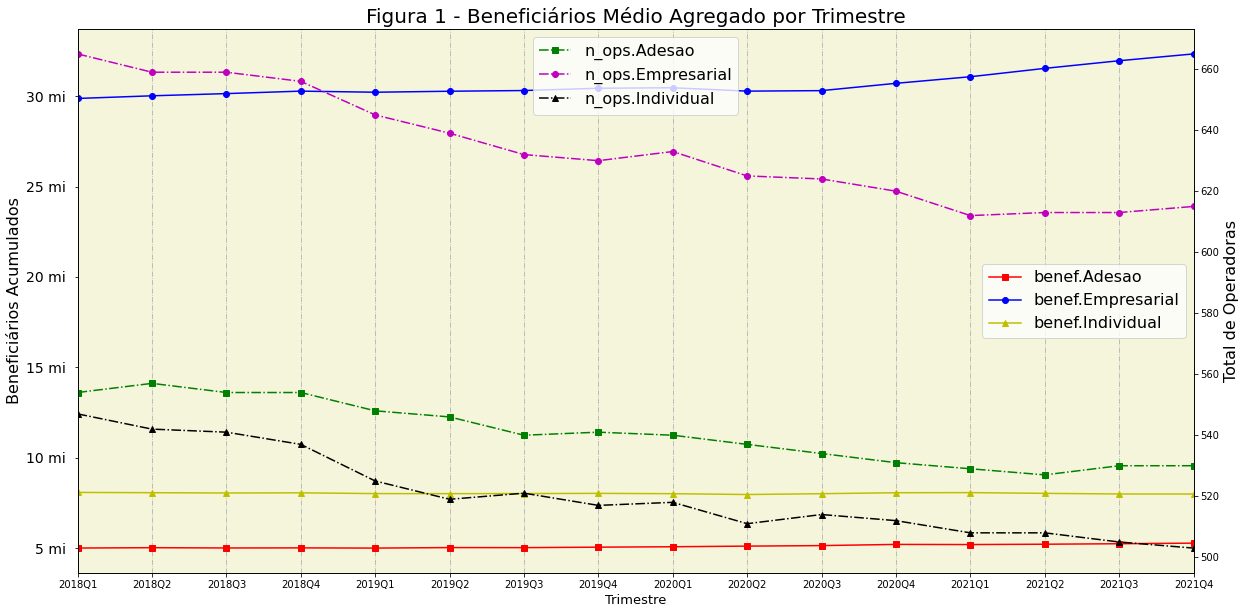

In [74]:
#Plotagem da quantidade beneficiarios e total de operadoras por tipo de contratacao
df_plot = sib_filtrada_analise.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['benef.Adesao','benef.Empresarial','benef.Individual'], figsize=(20,10), style=['rs-','bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Beneficiários Médio Agregado por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['{:.0f} mi '.format(x/1e6) for x in yticks], fontsize = 14)
ax1.set_ylabel('Beneficiários Acumulados', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops.Adesao','n_ops.Empresarial','n_ops.Individual'], figsize=(20,10), style=['gs-.','mo-.','k^-.'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [75]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.667,4,3


In [76]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

#sib_filtrada.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '05-sib3.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
7,2017,27,P,Empresarial,Pre-estabelecido,2017-12-01,2017Q4,17190
8,2017,27,P,Individual,Pre-estabelecido,2017-09-01,2017Q3,631
...,...,...,...,...,...,...,...,...
106440,2022,422771,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,91
106442,2022,422827,P,Adesao,Pre-estabelecido,2022-03-01,2022Q1,33
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646


In [77]:
sib_filtrada_analise_2 = sib_filtrada.groupby(['contratacao', 'ano', 'trimestre'],  as_index=False).agg({ 'benef':lambda x: round(sum(x),0),
                                                                                                          'cd_ops':lambda x: x.nunique()})

#sib_filtrada_analise_2.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '17-sib_analise2_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada_analise_2 = sib_filtrada_analise_2[['trimestre','ano','contratacao','cd_ops','benef']]

sib_filtrada_analise_2 = sib_filtrada_analise_2.sort_values(['trimestre','ano','contratacao','cd_ops','benef'], ascending=[True, True, True, False, False]).reset_index(drop=True)

sib_filtrada_analise_2.head(20)

,trimestre,ano,contratacao,cd_ops,benef
0,2017Q3,2017,Adesao,555,5037647
1,2017Q3,2017,Empresarial,667,29854987
2,2017Q3,2017,Individual,553,8127618
3,2017Q4,2017,Adesao,554,5017839
4,2017Q4,2017,Empresarial,665,29918515
5,2017Q4,2017,Individual,547,8093375
6,2018Q1,2018,Adesao,553,5002413
7,2018Q1,2018,Empresarial,661,29872191
8,2018Q1,2018,Individual,544,8066185
9,2018Q2,2018,Adesao,555,5021061


### Leitura da base Cadop - Operadoras de planos de saúde Ativas

Na célula de código abaixo é realizado a leitura e o tratamento das bases com as informações de beneficiarios

[link para página com a base cadop](https://dados.gov.br/dataset/operadoras-de-planos-privados-de-saude)

In [78]:
#################################################################################################################################
#OPERADORAS
################################################################################################################################

path_operadoras = r'D:\TCC\TCC\Cadop'

#Lista com todos os nomes dos arquivos csv contidos na pasta
text_files_operadoras = [f for f in os.listdir(path_operadoras) if f.endswith(".csv")] 

#Leitura e concatenação de todas as bases
cadop = pd.concat([pd.read_csv(path_operadoras+'\\'+f, sep=';', encoding="ANSI") for f in text_files_operadoras]) 

#Reordenando as colunas
cadop = cadop[['CD_OPERADO', 'RAZAO_SOCIAL', 'MODALIDADE', 'DATA_REGISTRO_ANS', 'DATA_DESCREDENCIAMENTO']]

#Renomenado as colunas
cadop.columns = ['cd_ops', 'razao_social', 'modalidade', 'dt_registro', 'dt_cancelamento']

#Convertando o campo 'dt_registro' para tipo datetime
cadop['dt_registro'] = pd.to_datetime(cadop['dt_registro'], dayfirst=True)

#Convertando o campo 'dt_cancelamento' para tipo datetime
cadop['dt_cancelamento'] = pd.to_datetime(cadop['dt_cancelamento'], dayfirst=True)

#Merge das bases Cadop e Ops
cadop = pd.merge(cadop, ops, on='cd_ops', how='left')

cadop.drop(['benef'], axis='columns', inplace=True)

cadop['port_ops'] = cadop['port_ops'].fillna('Pequeno')

cadop['modalidade'] = cadop['modalidade'].str.replace('Seguradora Especializada em Saúde','Seguradora')

cadop = cadop.loc[cadop['modalidade'].isin(['Autogestão', 'Cooperativa Médica', 'Filantropia', 'Medicina de Grupo', 'Seguradora'])]

cadop['ano - dt_cancelamento'] = cadop['dt_cancelamento'].dt.year

cadop['ano - dt_registro'] = cadop['dt_registro'].dt.year

cadop['lg_cancelada'] = np.select([cadop['ano - dt_cancelamento'] <= 2021, (cadop['ano - dt_cancelamento'] != "NaN")],[1,0]) # Filtro de fim da Operação

cadop['lg_nova_ops'] = np.where(cadop['ano - dt_registro'] >= 2018, 1, 0) # Filtro de inicio da Operação

cadop = cadop[['cd_ops', 'razao_social', 'modalidade', 'port_ops', 'lg_cancelada', 'lg_nova_ops']]

cadop['cd_ops'] = cadop['cd_ops'].astype('str')

cadop

,cd_ops,razao_social,modalidade,port_ops,lg_cancelada,lg_nova_ops
0,418374,CAIXA DE ASSISTÊNCIA DO SETOR DE ENERGIA -EVIDA -ASSISTÊNCIA À SAÚDE,Autogestão,Pequeno,0,0
3,421421,2CARE OPERADORA DE SAÚDE LTDA.,Medicina de Grupo,Médio,0,1
5,406708,A.P.S ASSISTÊNCIA PERSONALIZADA À SAÚDE LTDA,Medicina de Grupo,Pequeno,0,0
9,314668,ABERTTA SAÚDE - ASSOCIAÇÃO BENEFICENTE DOS EMPREGADOS DA ARCELORMITTAL NO BRASIL,Autogestão,Médio,0,0
16,419168,ADPART M2 ADMINISTRAÇÃO E PARTICIPAÇÕES LTDA,Medicina de Grupo,Pequeno,0,0
...,...,...,...,...,...,...
4022,345628,WMS SUPERMERCADOS DO BRASIL LTDA,Autogestão,Pequeno,1,0
4023,320633,WOLF EQUIPAMENTOS DE PERFURAÇÃO LTDA,Autogestão,Pequeno,1,0
4025,327492,WORLD MED CARD SISTEMAS E LANÇAMENTOS LTDA,Medicina de Grupo,Pequeno,1,0
4026,339750,WS OPERADORA DE PLANOS DE SAÚDE LTDA - EM LIQUIDAÇÃO EXTRAJUDICIAL,Medicina de Grupo,Pequeno,1,0


## Cáculo da Receita e Despesa por trimetres (desacumulado)

In [79]:

############################################################################################################################################################################################
#                                                                                           DIOPS TCC
############################################################################################################################################################################################

#Cópia da base diops acumulada
diops_temp = diops.copy()

diops_temp['ref1'] = (  diops_temp['cd_ops'].map(str) + 
                        diops_temp['vigencia'].map(str) + 
                        diops_temp['contratacao'].map(str) + 
                        diops_temp['financiamento'].map(str) + 
                        diops_temp['ano'].map(str))

diops_temp['ref2'] = (  diops_temp['cd_ops'].map(str) + 
                        diops_temp['vigencia'].map(str) + 
                        diops_temp['contratacao'].map(str) + 
                        diops_temp['financiamento'].map(str) + 
                        diops_temp['ano'].map(str) + 
                        diops_temp['trimestre'].map(str))

#Cálculo das diferenças dos valores acumulados
diops_receita_temp = diops_temp[['ref1', 'ref2', 'receita']]

diops_receita_temp =  diops_receita_temp.set_index(['ref1', 'ref2']).sort_index()[['receita']]
diops_receita_temp['dif_receita'] = np.nan
idx = pd.IndexSlice

for ix in diops_receita_temp.index.levels[0]:
    diops_receita_temp.loc[ idx[ix,:], 'dif_receita'] = diops_receita_temp.loc[idx[ix,:],'receita'].diff()
    
diops_despesa_temp = diops_temp[['ref1', 'ref2', 'despesa']]

diops_despesa_temp =  diops_despesa_temp.set_index(['ref1', 'ref2']).sort_index()[['despesa']]
diops_despesa_temp['dif_despesa'] = np.nan
idx = pd.IndexSlice

for ix in diops_despesa_temp.index.levels[0]:
    diops_despesa_temp.loc[ idx[ix,:], 'dif_despesa'] = diops_despesa_temp.loc[idx[ix,:],'despesa'].diff()

diops_temp1 =  pd.merge(diops_temp, diops_receita_temp, on='ref2', how='left')

diops_temp2 =  pd.merge(diops_temp1, diops_despesa_temp, on='ref2', how='left')

diops_tcc = diops_temp2.drop(columns = ['ref1','ref2', 'receita_y', 'despesa_y'])

diops_tcc.dif_receita.fillna(diops_tcc.receita_x, inplace=True)

diops_tcc.dif_despesa.fillna(diops_tcc.despesa_x, inplace=True)

diops_tcc = diops_tcc.drop(columns = ['receita_x', 'despesa_x'])

diops_tcc.rename(columns = {'dif_receita':'receita', 'dif_despesa':'despesa'}, inplace = True)

del diops_temp, diops_receita_temp, diops_despesa_temp, diops_temp1, diops_temp2

#print('diops_tcc')
#print(diops_tcc)

#diops_tcc.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '04-diops_trimestral_tcc.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc['receita'] = diops_tcc['receita'].abs()

diops_tcc['despesa'] = diops_tcc['despesa'].abs()

diops_tcc = diops_tcc[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','receita','despesa']]

diops_tcc

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa
0,2017,27,A,Individual,Pre-estabelecido,2017-09-01,2017Q3,12981.240,0.000
1,2017,27,A,Individual,Pre-estabelecido,2017-12-01,2017Q4,4840.320,0.000
2,2018,27,A,Individual,Pre-estabelecido,2018-03-01,2018Q1,4465.750,0.000
3,2018,27,A,Individual,Pre-estabelecido,2018-06-01,2018Q2,4296.180,0.000
4,2018,27,A,Individual,Pre-estabelecido,2018-09-01,2018Q3,4374.970,0.000
...,...,...,...,...,...,...,...,...,...
60307,2021,884,P,Individual,Pre-estabelecido,2021-03-01,2021Q1,489740.570,6408902.090
60308,2021,884,P,Individual,Pre-estabelecido,2021-06-01,2021Q2,512590.700,7828274.480
60309,2021,884,P,Individual,Pre-estabelecido,2021-09-01,2021Q3,495429.070,7919663.050
60310,2021,884,P,Individual,Pre-estabelecido,2021-12-01,2021Q4,472883.470,7363137.440


## Reunião das Bases

Junção das bases receita e despesas com as informações de quantidade de beneficiarios e operadoras

In [80]:
#A Base com as informações reunidas recebe o nome de ANS.CSV
ans = pd.merge(diops_tcc,sib_filtrada, how='left', on=['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre'])

ans = pd.merge(ans,cadop, how='left', on=['cd_ops'])

ans = ans[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'trimestre', 'receita', 'despesa', 'benef', 'lg_cancelada', 'lg_nova_ops']]


ans.to_csv(f'D:/TCC/TCC/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2017,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2017-09-01,2017Q3,12981.240,0.000,NaN,1.000,0.000
1,2017,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2017-12-01,2017Q4,4840.320,0.000,NaN,1.000,0.000
2,2018,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2018-03-01,2018Q1,4465.750,0.000,NaN,1.000,0.000
3,2018,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2018-06-01,2018Q2,4296.180,0.000,NaN,1.000,0.000
4,2018,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2018-09-01,2018Q3,4374.970,0.000,NaN,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60307,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-03-01,2021Q1,489740.570,6408902.090,64.000,0.000,0.000
60308,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-06-01,2021Q2,512590.700,7828274.480,63.000,0.000,0.000
60309,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-09-01,2021Q3,495429.070,7919663.050,62.000,0.000,0.000
60310,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-12-01,2021Q4,472883.470,7363137.440,62.000,0.000,0.000


In [81]:
ans_analise = ans.groupby(['ano','trimestre'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': lambda x: sum_million(x),
                                                                    'cd_ops':lambda x: x.nunique()})

ans_analise['pct_despesa'] = ans_analise.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_analise.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_analise = ans_analise[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_analise = ans_analise[(ans_analise.trimestre > '2017Q4') & (ans_analise.trimestre < '2022Q1')]

ans_analise.set_index('trimestre', inplace=True)

ans_analise.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   receita      16 non-null     float64
 1   despesa      16 non-null     float64
 2   benef        16 non-null     float64
 3   n_ops        16 non-null     int64  
 4   pct_despesa  16 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 768.0 bytes


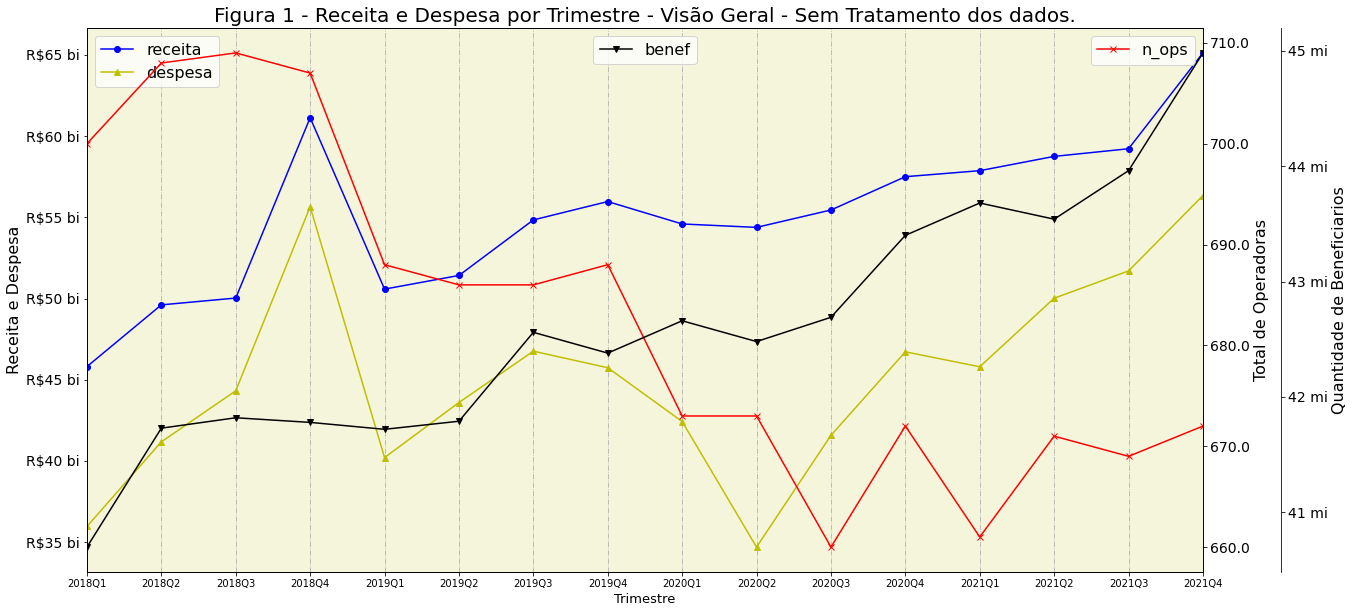

In [82]:
# Plotagem da visão geral de receita e despesa e beneficiarios
df_plot = ans_analise.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Visão Geral - Sem Tratamento dos dados.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [83]:
#Cria o rankin das operadoras com maior receita e despesa
ans_agrup_ops = ans.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x),
                                                                                'benef': 'sum'})

ans_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_agrup_ops = ans_agrup_ops.sort_values(['benef','receita'],ascending = False).groupby('trimestre').head(100).reset_index()

ans_agrup_ops.head()

,index,ano,cd_ops,trimestre,receita,despesa,benef
0,12759,2022,368253,2022Q1,2289.790,1765.120,3675618.000
1,11329,2021,368253,2021Q4,2262.400,1667.970,3649027.000
2,373,2017,326305,2017Q4,4744.980,3997.360,3457970.000
3,2166,2018,326305,2018Q4,5191.410,4433.280,3446153.000
4,2163,2018,326305,2018Q1,4851.790,3758.270,3441392.000


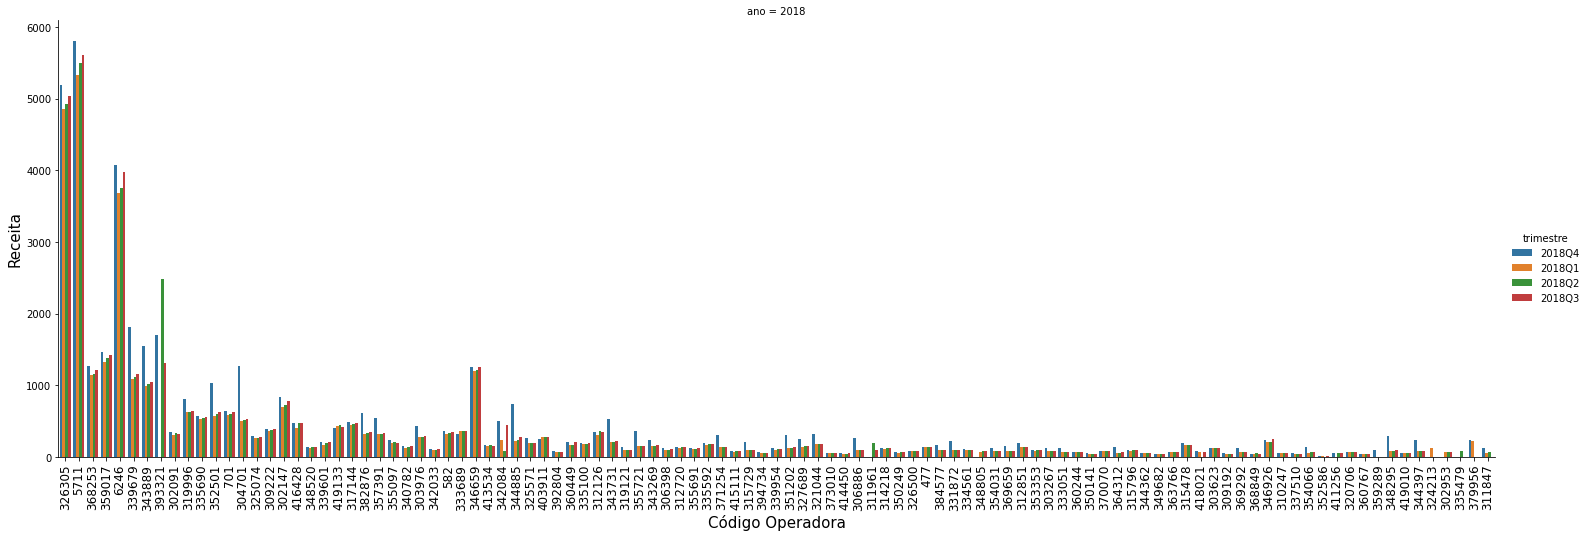

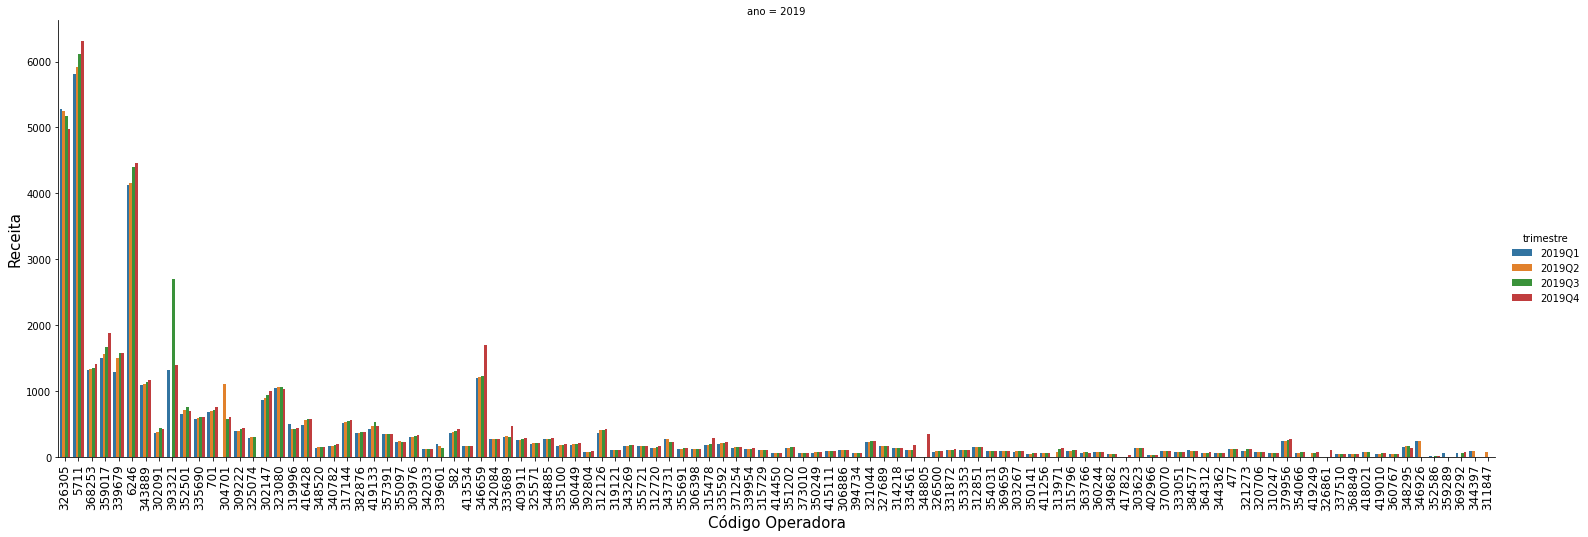

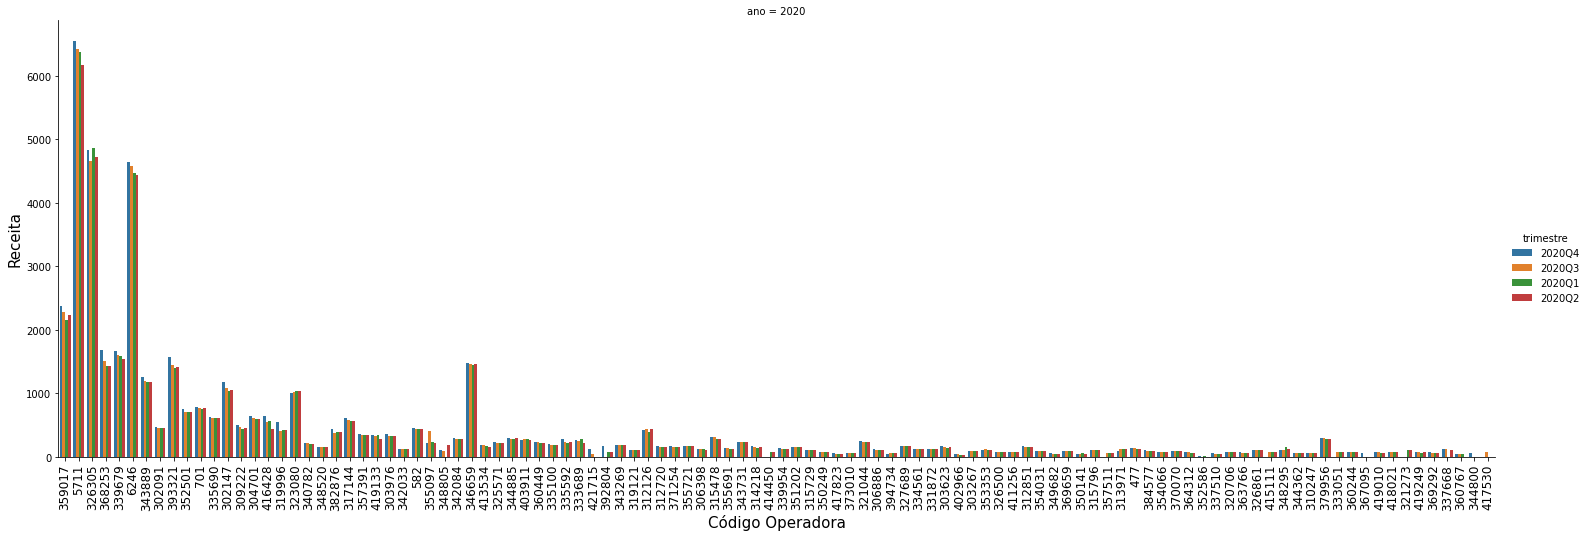

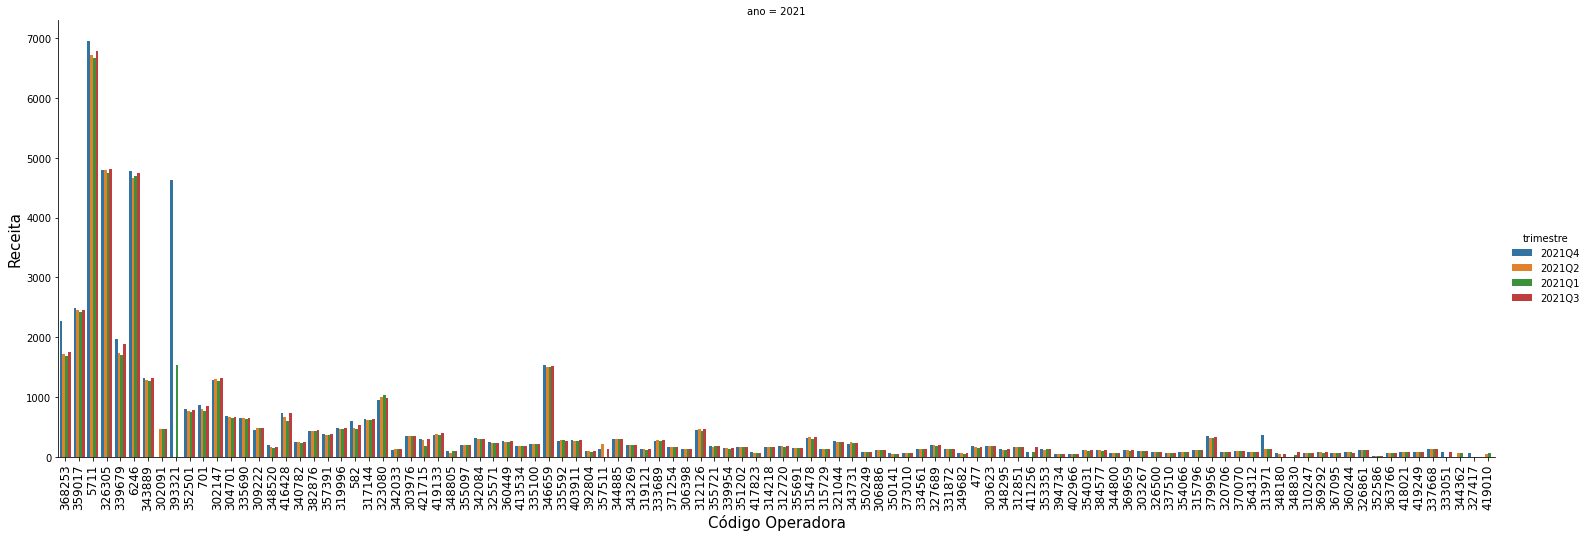

In [84]:
df_plot = ans_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

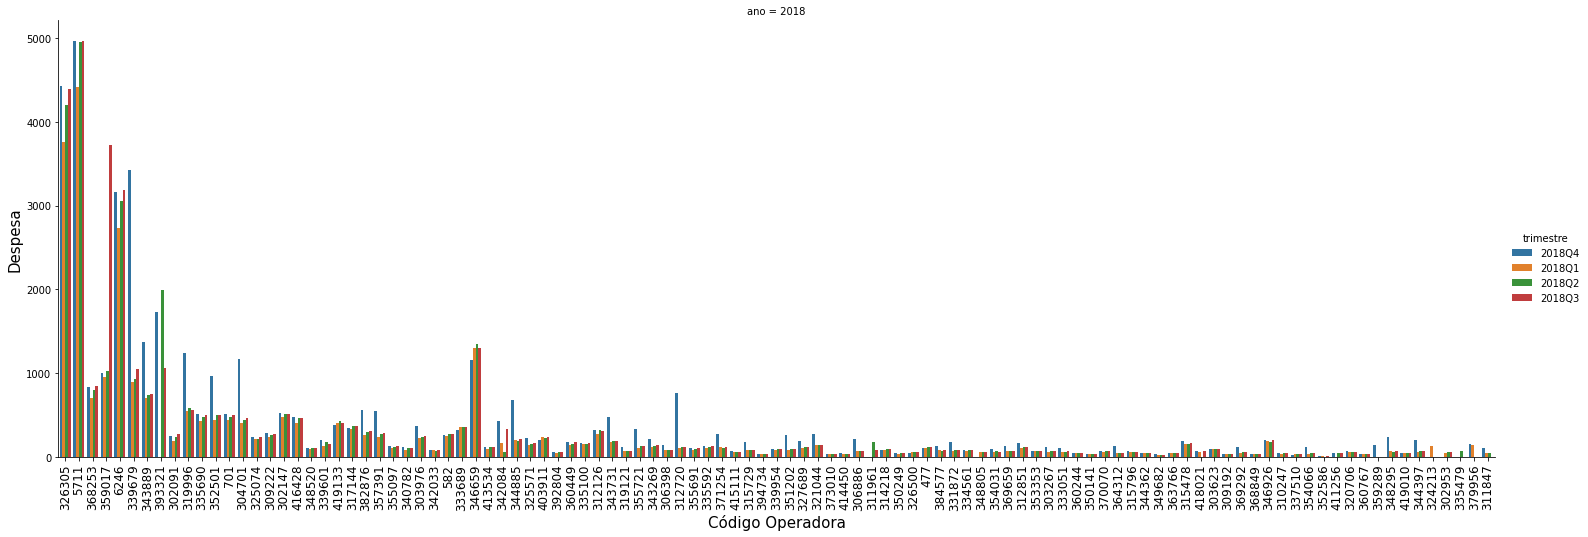

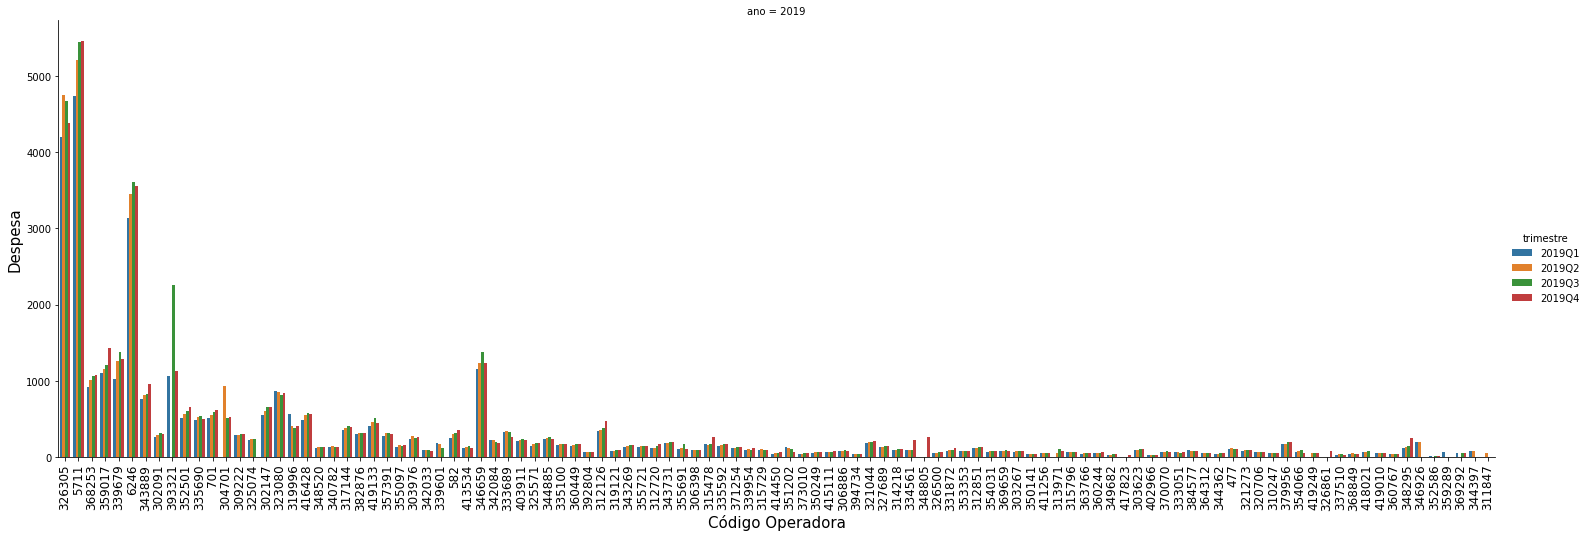

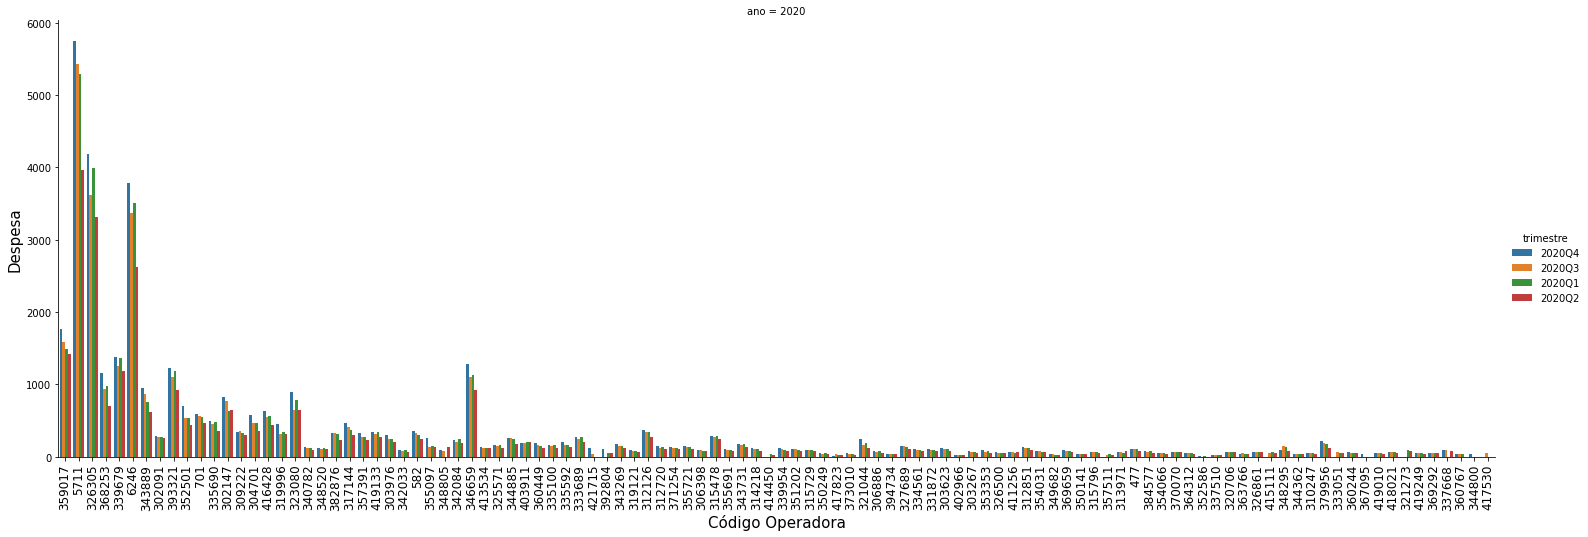

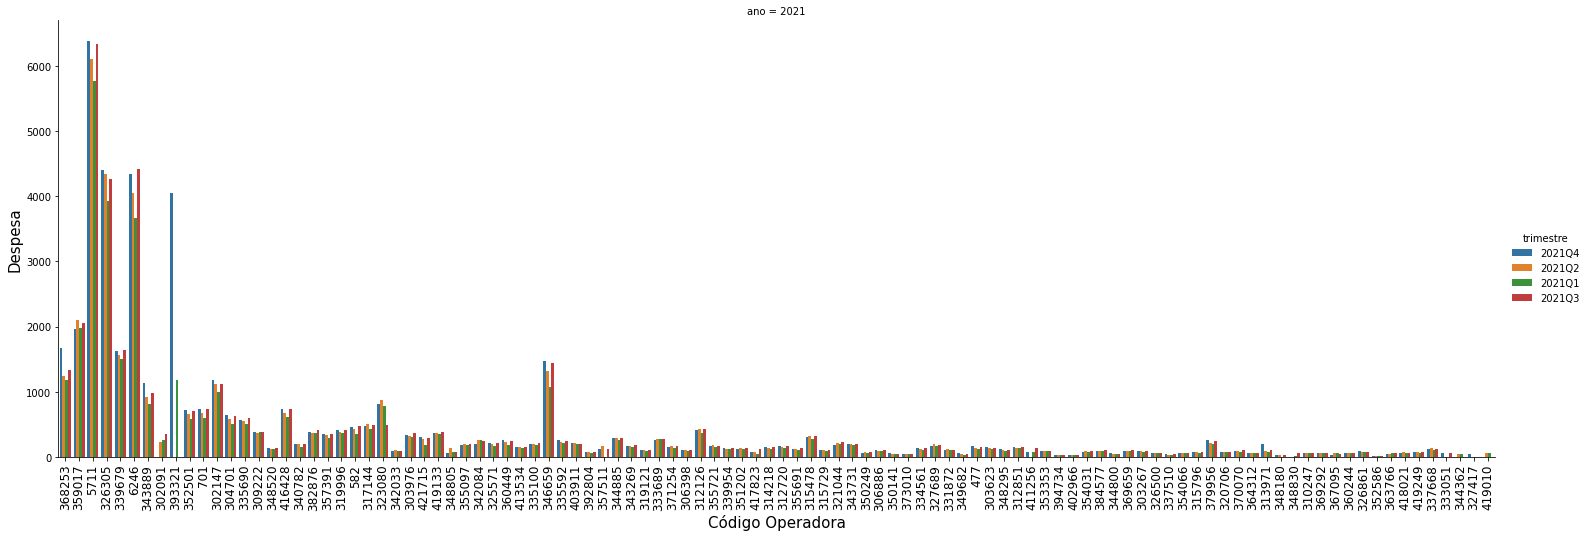

In [85]:
df_plot = ans_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Resumo